# 사전 학습된 모델 ConvNeXt


## 내용 요약 :
    - CNN 모델 기반 baseline을 구성하였으나 적은 데이터와 모델 구조의 한계점을 느껴서 사전 훈련 된 모델을 찾다가 ConvNeXt 모델을 알게 됨.
    - pytorch를 설치 후 ConvNeXt 모델을 불러오기 성공.
    - 확실히 학습 성능이 잘 나옴.
        - valid 정확도 82~84%, 컴퓨전 매트릭스로 많이 헷갈려하는 해파리의 종의 유무를 확인해보기.
        - 최종 태스트 정확도 90%, 컴퓨전 매트릭스로 많이 헷갈려하는 해파리의 종의 유무를 확인해보기.
        - 예상과 같이 blue와 moon 두 종류의 해파리를 헷갈려 하는 경향이 있었다.

**ConvNeXt** : CNN 구조를 현대적으로 개선하여, Vision Transformer (ViT) 와 같은 최신 모델들과도 견줄 만한 성능을 보여주는 차세대 CNN 아키텍처입니다.

- 장점 :
    - 복잡한 텍스처, 유사한 해파리 모양 등 고차원 시각 패턴 인식에 탁월

    - 데이터 양이 적더라도 전이학습 + fine-tuning으로 높은 성능 가능

- CNN vs. ConvNeXt 구조 차이 :
    - ConvNeXt는 CNN 구조를 Transformer의 아이디어로 리디자인한 CNN이다.
    - 연산 방식은 CNN이지만, 정규화와 활성화, 블록 구성은 Transformer와 유사하다.
    - 결과적으로 표현력은 높이고 계산 효율성도 유지하는 구조야.
    - 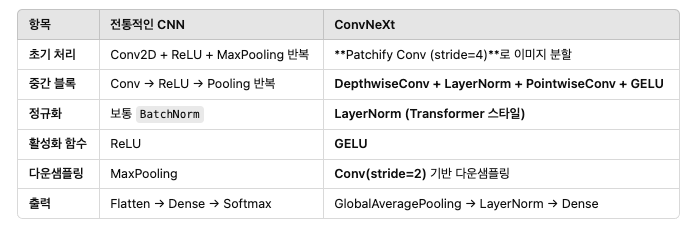
    - 관련 자료 : https://arxiv.org/abs/2201.03545

## pytotch를 사용하여 모델 불러오기.

### 0. pytorch install

In [ ]:
!pip install --upgrade torch torchvision torchaudio

### 1. 필요한 라이브러리 불러오기

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from torchvision import transforms
import os


###

In [2]:
# # 사전학습 모델에 맞는 전처리, 사전학습된 모델 불러오기
weights = ConvNeXt_Tiny_Weights.DEFAULT
model = convnext_tiny(weights=weights)

# 출력층만 6개 클래스로 수정
model.classifier[2] = nn.Linear(model.classifier[2].in_features, 6)

# 가능하면 GPU 사용하고, 안될 시 CPU 사용.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 152MB/s]


### 2. 새 파일에 데이터셋 불러오기.

In [4]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"haeun0186","key":"67e82d38e62e93a428c238cd8469821e"}'}

In [5]:
# kaggle.json을 ~/.kaggle로 옮기기
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # 보안 권한 설정

# kaggle 라이브러리 설치
!pip install -q kaggle

# 데이터셋 다운로드 (jellyfish-types)
!kaggle datasets download -d anshtanwar/jellyfish-types

# 압축 풀기
!unzip -q jellyfish-types.zip

Dataset URL: https://www.kaggle.com/datasets/anshtanwar/jellyfish-types
License(s): Attribution 4.0 International (CC BY 4.0)


### 3. 데이터셋 할당하기

In [9]:
# 사전학습 모델에 맞는 전처리 진행
transform = weights.transforms()

train_data = ImageFolder('/content/Train_Test_Valid/Train', transform=transform)
val_data = ImageFolder('/content/Train_Test_Valid/valid', transform=transform)
test_data = ImageFolder('/content/Train_Test_Valid/test', transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

class_names = train_data.classes


### 4. 모델 세팅 및 학습

In [10]:
def evaluate(model, loader):
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

train_acc_list = []
val_acc_list = []
train_loss_list = []
best_val_acc = 0.0
best_model_path = "best_model.pth"

for epoch in range(20):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    val_acc = evaluate(model, val_loader)

    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    train_loss_list.append(train_loss)

    print(f"Epoch {epoch+1}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print("🔥 Best model saved!")


Epoch 1: Train Acc = 0.9989, Val Acc = 0.7692
🔥 Best model saved!
Epoch 2: Train Acc = 0.9956, Val Acc = 0.7436
Epoch 3: Train Acc = 1.0000, Val Acc = 0.8205
🔥 Best model saved!
Epoch 4: Train Acc = 1.0000, Val Acc = 0.7949
Epoch 5: Train Acc = 1.0000, Val Acc = 0.8205
Epoch 6: Train Acc = 1.0000, Val Acc = 0.8205
Epoch 7: Train Acc = 1.0000, Val Acc = 0.8205
Epoch 8: Train Acc = 1.0000, Val Acc = 0.7949
Epoch 9: Train Acc = 1.0000, Val Acc = 0.7436
Epoch 10: Train Acc = 1.0000, Val Acc = 0.8205
Epoch 11: Train Acc = 1.0000, Val Acc = 0.7949
Epoch 12: Train Acc = 1.0000, Val Acc = 0.7949
Epoch 13: Train Acc = 1.0000, Val Acc = 0.7949
Epoch 14: Train Acc = 1.0000, Val Acc = 0.7949
Epoch 15: Train Acc = 1.0000, Val Acc = 0.7949
Epoch 16: Train Acc = 1.0000, Val Acc = 0.7692
Epoch 17: Train Acc = 1.0000, Val Acc = 0.7692
Epoch 18: Train Acc = 1.0000, Val Acc = 0.7949
Epoch 19: Train Acc = 1.0000, Val Acc = 0.8205
Epoch 20: Train Acc = 1.0000, Val Acc = 0.8205


### 5. 최고 성능 모델을 불러와서 성능 평가 및 시각화 진행

In [13]:
# 학습 끝난 뒤 최고 성능 모델 불러오기
model.load_state_dict(torch.load(best_model_path))
model.eval()


ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

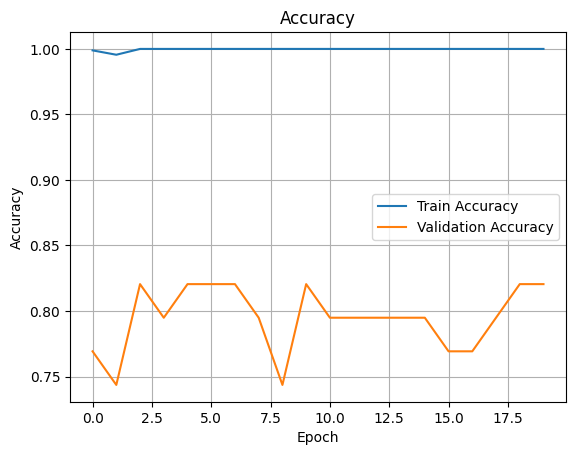

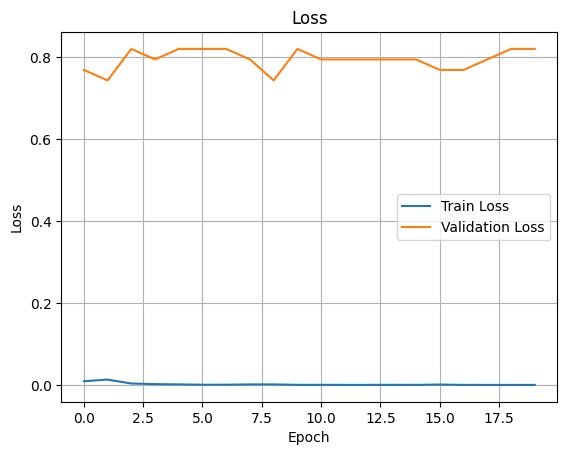

In [20]:
# 정확도 그래프
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# 손실 그래프
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_acc_list, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


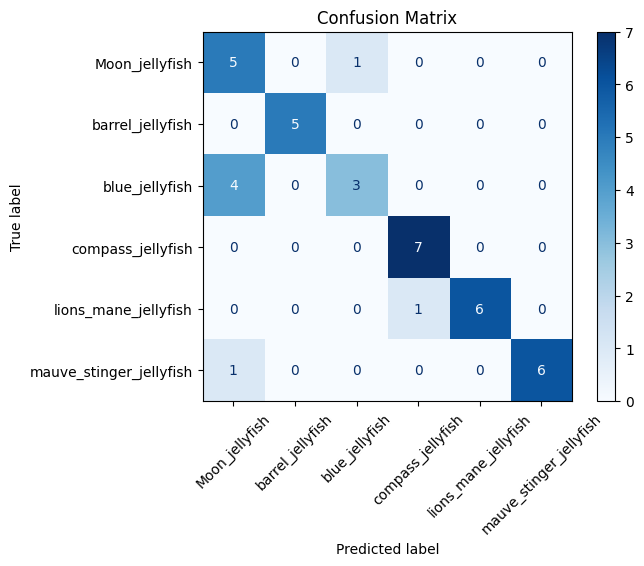

In [19]:
# 전체 예측 수집(valid)
y_pred, y_true = [], []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.numpy())

# 혼동 행렬 시각화
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


### 6. 테스트셋으로 최종 성능 평가 및 시각화

In [21]:
test_acc = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.9000


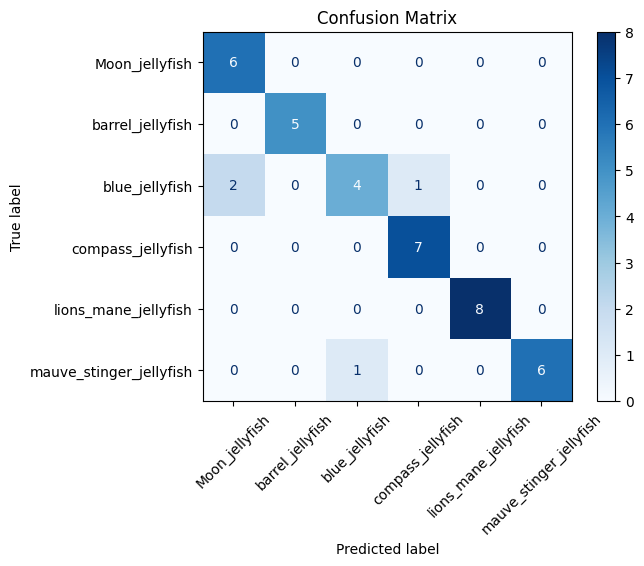

In [18]:
# 전체 예측 수집(test)
y_pred, y_true = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.numpy())

# 혼동 행렬 시각화
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()